* *Importing initial libraries ...*
* *Importing the functions from **precog_utils.py***

In [4]:
import importlib
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter 
from tqdm import tqdm
import precog_utils

nltk.download('punkt')
nltk.download('punkt_tab')
importlib.reload(precog_utils)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ojasvasaxena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ojasvasaxena/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<module 'precog_utils' from '/Users/ojasvasaxena/Desktop/Research/Precog_Hiring/precog_utils.py'>

### Pre-processing the Corpus
* Removing special characters
* Converting to lower case
* Removing the indexes from the sentences
* Tokeinizing all sentences

In [5]:
# load, tokenize and process the data
import re
from itertools import chain

with open('Corpora/eng_wiki_corpora.txt') as f:
    corpus = f.read()

# splitting the corpus sentencewise
sentences_corpus = corpus.split("\n")[:-1]

# TILL 10k FOR NOW
# sentences_corpus = sentences_corpus[:5000]

# replace special characters with "."   
sentences_corpus = [re.sub(r":|\[|\(|;|\]|\]|\)|\"|\'|\!|\?|\;|\,|\.", "", sentence) for sentence in sentences_corpus]

# getting sentences after removing the integers
sentences = []
for idx,sentence in enumerate(sentences_corpus):
    try:
        sentences.append(sentence.split("\t")[1].strip())
    except:
        print("Couldn't find a valid split for index:" , idx)

# tokenize each line
tokenized_corpus = [word_tokenize(line.lower()) for line in sentences]

# getting all words from all sentences
word_corpus = list(chain(*tokenized_corpus))

### Getting filtered corpus details
* Filtered Vocabulary (frequency <3 removed from vocab)
* Filtered Vocabulary Length
* Handling `<UNK>` tokens (novel tokens)
* Vocabulary Frequency Distribution
* Word_To_Index Dictionary

In [6]:
filtered_vocab , V , freq_dist , word_to_index = precog_utils.get_corpus_info(word_corpus , vocab_threshold=3)

Built frequency distribution ...
Filtering vocabulary ...
Vocabulary Size:  64831
Building Word-Index mapping ...
Handling <UNK> tokens ...
Most Common Words:  [('the', 444265), ('of', 213856), ('and', 173917), ('<UNK>', 164394), ('to', 156518), ('in', 154961), ('a', 135257), ('is', 69267), ('was', 58467), ('for', 53660)]


### Generate Co-Occurrence Matrix
* Returns the co-occurrence matrix for `context_window_size = 2` and `context_window_size = 5`
* Normalizes the matrices to get the Probability Matrix, which is better to be used as an embedding model
* These are the `(VxV)` size embeddings - V dimension for each row

In [7]:
co_occurrence_matrix_window_2 = precog_utils.get_co_occurence_matrix(V , word_corpus , filtered_vocab , word_to_index , context_window_size=2)
probability_matrix_window_2 = precog_utils.get_probability_matrix(co_occurrence_matrix_window_2)

co_occurrence_matrix_window_5 = precog_utils.get_co_occurence_matrix(V , word_corpus , filtered_vocab , word_to_index , context_window_size=5)
probability_matrix_window_5 = precog_utils.get_probability_matrix(co_occurrence_matrix_window_5)

100%|██████████| 6074330/6074330 [00:13<00:00, 445080.43it/s]


(64831, 64831)


100%|██████████| 6074330/6074330 [00:24<00:00, 243818.67it/s]


(64831, 64831)


### Manually printing some context words for "machine"
* We see some difference between `context_window_size = 2` and `context_window_size = 5`
* `context_window_size = 5` seems to pick up on a little more nuance

In [8]:
# get some context words (context window 2)
precog_utils.get_context(probability_matrix_window_2 , "machine" , filtered_vocab , word_corpus , word_to_index)[:20]

['usually',
 'human',
 'commercial',
 'were',
 'electronic',
 'its',
 'might',
 'powerful',
 'powered',
 'second',
 'primitive',
 'against',
 'is',
 'failed',
 'could',
 'it',
 'cash',
 'host',
 'talking',
 'machine']

In [9]:
# get some context words (context window 5)
precog_utils.get_context(probability_matrix_window_5 , "machine" , filtered_vocab , word_corpus , word_to_index)[:20]

['win',
 'usually',
 'army',
 'compiled',
 'prior',
 'operation',
 'attacks',
 'formed',
 'retrieved',
 'human',
 'front',
 'readable',
 'rounds',
 'specific',
 'commercial',
 'were',
 'major',
 'distance',
 'acts',
 'stone']

### Getting COMPACT and DISTILLED embeddings using TruncatedSVD
* Compact embedding length: `sqrt(V)` (new marix size `V x sqrt(V)`) ***(`sqrt(v)` is a common heuristic)***
* Distilled embedding length: 20 (new marix size `Vx20`)
* Reducing the embedding size of both `context_window_size = 2` and `context_window_size = 5` matrices

In [10]:
# reduce dimensions of the embeddings (a common heuristic is sqrt(total dims) )
embeddings_window_2 = precog_utils.get_smaller_matrices(probability_matrix_window_2 , dim1=400 , dim2=int(V**.5) , dim3=10)

Smaller Matrix Shape: (64831, 254)
Smaller Matrix Shape: (64831, 10)


In [11]:
# reduce dimensions of the embeddings (a common heuristic is sqrt(total dims) )
embeddings_window_5 = precog_utils.get_smaller_matrices(probability_matrix_window_5 , dim1=400 , dim2=int(V**.5) , dim3=10)

Smaller Matrix Shape: (64831, 254)
Smaller Matrix Shape: (64831, 10)


### Manual Evaluation: Similarity between related and unrelated words
* Let's see how our embeddings (over various context lengths and embedding dimensions) for some words:
  * > **achievement** and **triumph** - similar words, high similarity expected
  * > **disdain** and **zebra** - unrelated words, low similarity expected
  * > **market** and **economics** - related words, high similarity expected
* Note the difference between *similar* and *related* words.

In [12]:
# similarity between similar and different words

word1_idx = precog_utils.get_processed_token_idx("achievement" , filtered_vocab , word_to_index)
word2_idx = precog_utils.get_processed_token_idx("triumph" , filtered_vocab , word_to_index) # related words, high similarity expected

word3_idx = precog_utils.get_processed_token_idx("disdain" , filtered_vocab , word_to_index)
word4_idx = precog_utils.get_processed_token_idx("zebra" , filtered_vocab , word_to_index) # unrelated words, low similarity expected

word5_idx = precog_utils.get_processed_token_idx("market" , filtered_vocab , word_to_index)
word6_idx = precog_utils.get_processed_token_idx("economics" , filtered_vocab , word_to_index) # related words, high similarity expected

In [32]:
# model_reduced_w2 = embeddings_window_2["reduced"][1]
# model_reduced_w5 = embeddings_window_5["reduced"][1]

model_compact_w2 = embeddings_window_2["compact"][1]
model_compact_w5 = embeddings_window_5["compact"][1]

model_distilled_w2 = embeddings_window_2["distilled"][1]
model_distilled_w5 = embeddings_window_5["distilled"][1]

#### Comparing Reduced Models: `context_window_size = 2` vs `context_window_size = 5`

In [33]:
# print(f"Reduced Co-Occurrence Similarities (400 dimensions) - Window Size 2")
# print(f"Similarity(achievement , triumph) : {precog_utils.cosine_similarity(model_reduced_w2[word1_idx] , model_reduced_w2[word2_idx]):.4f}")
# print(f"Similarity(disdain , zebra) : {precog_utils.cosine_similarity(model_reduced_w2[word3_idx] , model_reduced_w2[word4_idx]):.4f}")
# print(f"Similarity(market , economics) : {precog_utils.cosine_similarity(model_reduced_w2[word5_idx] , model_reduced_w2[word6_idx]):.4f}")

# print("---")

# print("Reduced Co-Occurrence Similarities (400 dimensions) - Window Size 5")
# print(f"Similarity(achievement , triumph) : {precog_utils.cosine_similarity(model_reduced_w5[word1_idx] , model_reduced_w5[word2_idx]):.4f}")
# print(f"Similarity(disdain , zebra) : {precog_utils.cosine_similarity(model_reduced_w5[word3_idx] , model_reduced_w5[word4_idx]):.4f}")
# print(f"Similarity(market , economics) : {precog_utils.cosine_similarity(model_reduced_w5[word5_idx] , model_reduced_w5[word6_idx]):.4f}")

In [61]:
model_compact_w2[word1_idx].shape , model_compact_w2[word2_idx].shape

((254,), (254,))

#### Comparing Compact Models: `context_window_size = 2` vs `context_window_size = 5`

In [34]:
print(f"Compact Co-Occurrence Similarities (sqrt(V) dimensions) - Window Size 2")
print(f"Similarity(achievement , triumph) : {precog_utils.cosine_similarity(model_compact_w2[word1_idx] , model_compact_w2[word2_idx]):.4f}")
print(f"Similarity(disdain , zebra) : {precog_utils.cosine_similarity(model_compact_w2[word3_idx] , model_compact_w2[word4_idx]):.4f}")
print(f"Similarity(market , economics) : {precog_utils.cosine_similarity(model_compact_w2[word5_idx] , model_compact_w2[word6_idx]):.4f}")

print("---")

print("Original Co-Occurrence Similarities (sqrt(V) dimensions) - Window Size 5")
print(f"Similarity(achievement , triumph) : {precog_utils.cosine_similarity(model_compact_w5[word1_idx] , model_compact_w5[word2_idx]):.4f}")
print(f"Similarity(disdain , zebra) : {precog_utils.cosine_similarity(model_compact_w5[word3_idx] , model_compact_w5[word4_idx]):.4f}")
print(f"Similarity(market , economics) : {precog_utils.cosine_similarity(model_compact_w5[word5_idx] , model_compact_w5[word6_idx]):.4f}")

Compact Co-Occurrence Similarities (sqrt(V) dimensions) - Window Size 2
Similarity(achievement , triumph) : 0.8857
Similarity(disdain , zebra) : 0.2548
Similarity(market , economics) : 0.6547
---
Original Co-Occurrence Similarities (sqrt(V) dimensions) - Window Size 5
Similarity(achievement , triumph) : 0.9486
Similarity(disdain , zebra) : 0.6272
Similarity(market , economics) : 0.9028


#### Comparing Distilled Models: `context_window_size = 2` vs `context_window_size = 5`

In [35]:
print(f"Distilled Co-Occurrence Similarities (10 dimensions) - Window Size 2")
print(f"Similarity(achievement , triumph) : {precog_utils.cosine_similarity(model_distilled_w2[word1_idx] , model_distilled_w2[word2_idx]):.4f}")
print(f"Similarity(disdain , zebra) : {precog_utils.cosine_similarity(model_distilled_w2[word3_idx] , model_distilled_w2[word4_idx]):.4f}")
print(f"Similarity(market , economics) : {precog_utils.cosine_similarity(model_distilled_w2[word5_idx] , model_distilled_w2[word6_idx]):.4f}")

print("---")

print("Distilled Co-Occurrence Similarities (10 dimensions) - Window Size 5")
print(f"Similarity(achievement , triumph) : {precog_utils.cosine_similarity(model_distilled_w5[word1_idx] , model_distilled_w5[word2_idx]):.4f}")
print(f"Similarity(disdain , zebra) : {precog_utils.cosine_similarity(model_distilled_w5[word3_idx] , model_distilled_w5[word4_idx]):.4f}")
print(f"Similarity(market , economics) : {precog_utils.cosine_similarity(model_distilled_w5[word5_idx] , model_distilled_w5[word6_idx]):.4f}")

Distilled Co-Occurrence Similarities (10 dimensions) - Window Size 2
Similarity(achievement , triumph) : 0.9436
Similarity(disdain , zebra) : 0.6269
Similarity(market , economics) : 0.6660
---
Distilled Co-Occurrence Similarities (10 dimensions) - Window Size 5
Similarity(achievement , triumph) : 0.9809
Similarity(disdain , zebra) : 0.8606
Similarity(market , economics) : 0.9147


#### Visualizing Similarities: `dimension = 254` vs `dimension = 10` (`context size = 2`)

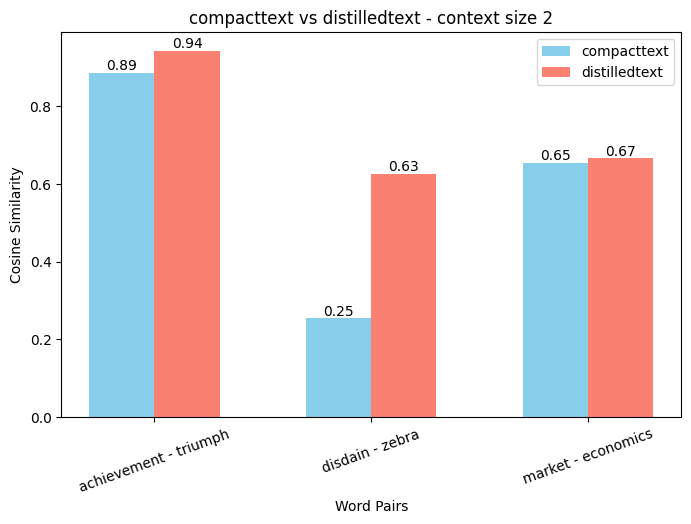

In [36]:
# viusalizing similarities - compact vs distilled window 2

import matplotlib.pyplot as plt

word_pairs = ["achievement - triumph", "disdain - zebra", "market - economics"]

similarities_window2_compact = [0.8859, 0.2542, 0.6548]
similarities_window2_distilled = [0.9438, 0.6262, 0.6660]

x = np.arange(len(word_pairs))
width = 0.3  
fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(x - width/2, similarities_window2_compact, width, label="compacttext", color="skyblue")
bars2 = ax.bar(x + width/2, similarities_window2_distilled, width, label="distilledtext", color="salmon")

ax.set_xlabel("Word Pairs")
ax.set_ylabel("Cosine Similarity")
ax.set_title("compacttext vs distilledtext - context size 2")
ax.set_xticks(x)
ax.set_xticklabels(word_pairs, rotation=20)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.show()

#### Visualizing Similarities: `dimension = 254` vs `dimension = 10` (`context size = 5`)

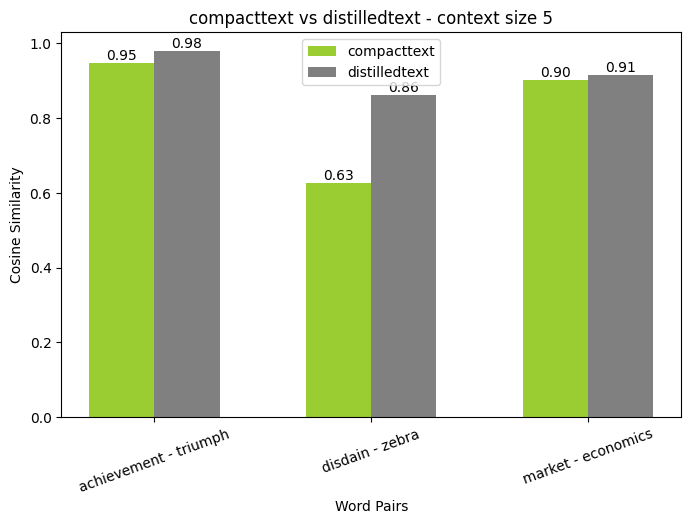

In [37]:
# viusalizing similarities - compact vs distilled window 5

import matplotlib.pyplot as plt

word_pairs = ["achievement - triumph", "disdain - zebra", "market - economics"]

similarities_window5_compact = [0.9486, 0.6270, 0.9024]
similarities_window5_distilled = [0.9809, 0.8610, 0.9148]

x = np.arange(len(word_pairs))
width = 0.3  
fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(x - width/2, similarities_window5_compact, width, label="compacttext", color="yellowgreen")
bars2 = ax.bar(x + width/2, similarities_window5_distilled, width, label="distilledtext", color="grey")

ax.set_xlabel("Word Pairs")
ax.set_ylabel("Cosine Similarity")
ax.set_title("compacttext vs distilledtext - context size 5")
ax.set_xticks(x)
ax.set_xticklabels(word_pairs, rotation=20)
ax.legend()

# Show values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.show()

#### Using PCA/t-SNE to visualize spread of embeddings in reduced 2D vector space

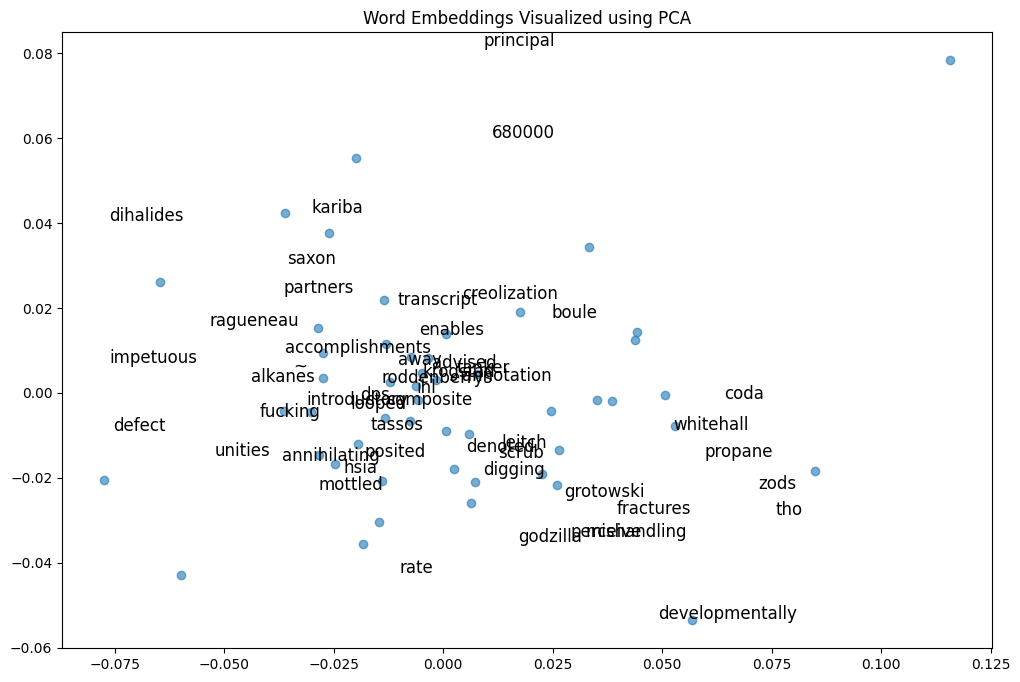

In [38]:
from sklearn.decomposition import PCA
import random

# apply PCA
pca = PCA(n_components=2)
pca.fit(model_compact_w5)
embeddings_pca = pca.transform(model_compact_w5)

samples = 50
start = random.randint(0 , len(filtered_vocab)-samples)
end = start+samples

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_pca[start:end, 0], embeddings_pca[start:end, 1], alpha=0.6)

for i, word in enumerate(list(filtered_vocab)[start:end]):  # Annotating first 50 words
    plt.annotate(word, (embeddings_pca[i, 0], embeddings_pca[i, 1]), fontsize=12)

plt.title("Word Embeddings Visualized using PCA")
plt.show()

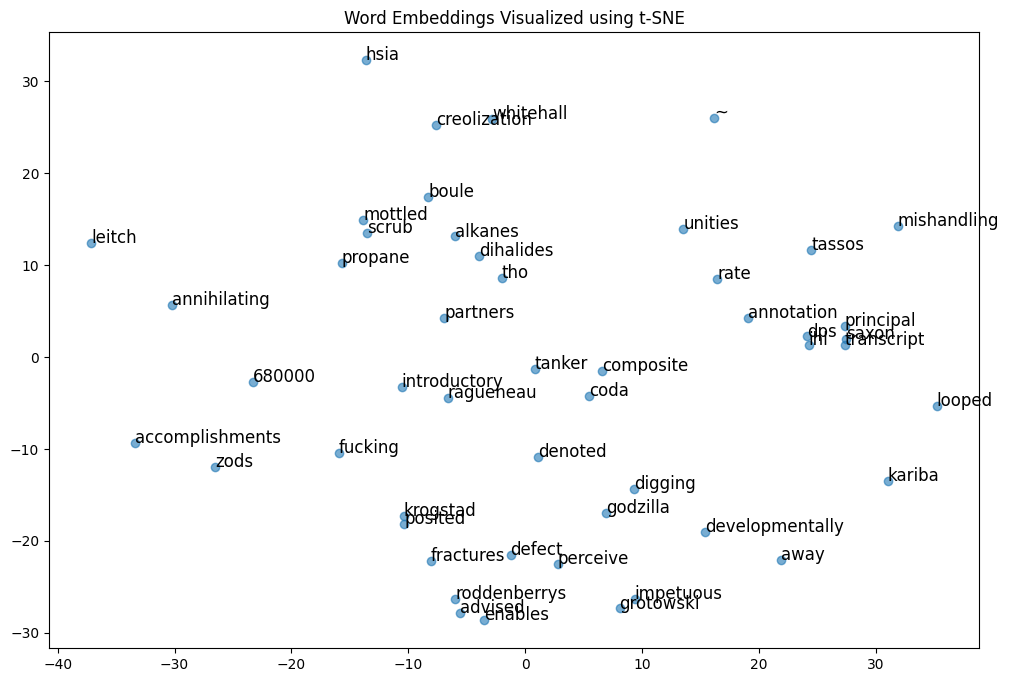

In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

pca = PCA(n_components=50)
model_reduced = pca.fit_transform(model_compact_w5)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate=200)
embeddings_tsne = tsne.fit_transform(model_reduced)

samples = 50
start = random.randint(0, len(filtered_vocab) - samples)
end = start + samples

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_tsne[start:end, 0], embeddings_tsne[start:end, 1], alpha=0.6)

for i, word in enumerate(list(filtered_vocab)[start:end]):
    plt.annotate(word, (embeddings_tsne[start + i, 0], embeddings_tsne[start + i, 1]), fontsize=12)

plt.title("Word Embeddings Visualized using t-SNE")
plt.show()

### Intrinsic Evaluations

#### Analogy Test (BATS)
* Loading the dataset from HuggingFace
* `A:B :: C:D`
* We are given `[A,B]` and we need to predict (using our embeddings) `[C,D]`
* Assessing accuracy metrics for our gerated embeddings, random prediction (control), FastText

In [40]:
from datasets import load_dataset

# analogy_ds_u4 = load_dataset("relbert/analogy_questions" , "u4" , split="test")
# analogy_ds_u4 = load_dataset("relbert/analogy_questions" , "conceptnet_relational_similarity" , split="test")
# analogy_ds_u4 = load_dataset("relbert/analogy_questions" , "nell_relational_similarity" , split="test")
# analogy_ds_u4 = load_dataset("relbert/analogy_questions" , "scan" , split="test")

analogy_ds_u4 = load_dataset("relbert/analogy_questions" , "bats" , split="test")

In [41]:
analogy_ds_u4

Dataset({
    features: ['stem', 'answer', 'choice', 'prefix'],
    num_rows: 1799
})

In [42]:
analogy_ds_u4['stem'][10] , analogy_ds_u4['choice'][10] , analogy_ds_u4['answer'][10]

(['newton', 'scientist'],
 [['fox', 'howl'],
  ['caesar', 'emperor'],
  ['aristotle', 'raphael'],
  ['andersen', 'wittgenstein']],
 1)

In [43]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import random

def analogy_eval(embedding_model):

    random.seed(42)

    questions = analogy_ds_u4["stem"]
    choices = analogy_ds_u4["choice"]
    answer = analogy_ds_u4["answer"]
    
    predictions = []
    random_predictions = []
    
    for i,(stem0 , stem1) in enumerate(questions):

        # print(f"For Question {i} ...")
        # print(ques)

        q_token1 = precog_utils.get_processed_token_idx(stem0 , filtered_vocab , word_to_index)
        q_token2 = precog_utils.get_processed_token_idx(stem1 , filtered_vocab , word_to_index)

        # diff between the question words
        q_dist = embedding_model[q_token2] - embedding_model[q_token1] # word2 - word1

        # all prediction diffs
        options_dist = []
        for (opt1 , opt2) in choices[i]:
            op_token1 = precog_utils.get_processed_token_idx(opt1 , filtered_vocab , word_to_index)
            op_token2 = precog_utils.get_processed_token_idx(opt2 , filtered_vocab , word_to_index)

            # diff between the current choices
            options_dist.append( embedding_model[op_token2] - embedding_model[op_token1] )
            
        best_score = -9999
        best_pair_idx = -1
        # getting predicted answer based on diff vecs
        for j,diff_vec in enumerate(options_dist):
            # for Q1, Q2, etc
            # print(f"For Option {j}, {choices[i][j]}")
            # getting max similarity score - final prediction
            score = precog_utils.cosine_similarity(q_dist , diff_vec)
            # print(f"Option {j} similarity: {score:.3f}")
            if score > best_score:
                best_score = score
                best_pair_idx = j

        # print(f"PRED ANS: {choices[i][best_pair_idx]}")
        # print(f"REAL ANS: {choices[i][answer[i]]}")
        # print("----------")
        predictions.append(best_pair_idx)
        random_predictions.append(random.randint(0 , len(choices[i])))
        
    # predictions classification report
    print("PREDICTION METRICS")
    precision, recall, f1_score, _ = precision_recall_fscore_support(answer, predictions, average='weighted')
    print(f"Accuracy: {accuracy_score(answer, predictions):.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

    print("---")
    # print("Classification Report (PREDICTIONS):\n", classification_report(answer, random_predictions))
    
    # random classification report
    print("RANDOM METRICS")
    precision, recall, f1_score, _ = precision_recall_fscore_support(answer, random_predictions, average='weighted')
    print(f"Accuracy: {accuracy_score(answer, random_predictions):.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

In [44]:
# analogy_eval(model_reduced_w2)

In [45]:
# analogy_eval(model_reduced_w5)

In [46]:
analogy_eval(model_compact_w2)

PREDICTION METRICS
Accuracy: 0.49
Precision: 0.49
Recall: 0.49
F1 Score: 0.49
---
RANDOM METRICS
Accuracy: 0.19
Precision: 0.24
Recall: 0.19
F1 Score: 0.22


/Users/ojasvasaxena/Desktop/Research/researchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
analogy_eval(model_compact_w5)

PREDICTION METRICS
Accuracy: 0.45
Precision: 0.45
Recall: 0.45
F1 Score: 0.45
---
RANDOM METRICS
Accuracy: 0.19
Precision: 0.24
Recall: 0.19
F1 Score: 0.22


/Users/ojasvasaxena/Desktop/Research/researchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
analogy_eval(model_distilled_w2)

PREDICTION METRICS
Accuracy: 0.36
Precision: 0.43
Recall: 0.36
F1 Score: 0.39
---
RANDOM METRICS
Accuracy: 0.19
Precision: 0.24
Recall: 0.19
F1 Score: 0.22


/Users/ojasvasaxena/Desktop/Research/researchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ojasvasaxena/Desktop/Research/researchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
analogy_eval(model_distilled_w5)

PREDICTION METRICS
Accuracy: 0.41
Precision: 0.41
Recall: 0.41
F1 Score: 0.41
---
RANDOM METRICS
Accuracy: 0.19
Precision: 0.24
Recall: 0.19
F1 Score: 0.22


/Users/ojasvasaxena/Desktop/Research/researchenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Analogy Test using FastText
* [Download Source](https://fasttext.cc/docs/en/english-vectors.html)

In [49]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())  # header (vocab size, dim)
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        # convert to numpy array
        data[tokens[0]] = np.array(list(map(float , tokens[1:])))
    return data

# load embeddings
fasttext_embeddings = load_vectors("Embeddings/fasttext_en.vec")  # FastText .vec file

In [50]:
def analogy_eval_fasttext(embedding_model):

    questions = analogy_ds_u4["stem"]
    choices = analogy_ds_u4["choice"]
    answer = analogy_ds_u4["answer"]
    
    predictions_fasttext = []
    
    for i,(stem1 , stem2) in enumerate(questions):

        # print(f"For Question {i} ...")
        # print(ques)

        # diff between the question words
        q_dist = precog_utils.get_fasttext_embedding(stem2 , embedding_model) - precog_utils.get_fasttext_embedding(stem1 , embedding_model) # word2 - word1

        # all prediction diffs
        options_dist = []
        for (opt1 , opt2) in choices[i]:
            # diff between the current choices
            options_dist.append( precog_utils.get_fasttext_embedding(opt2 , embedding_model) - precog_utils.get_fasttext_embedding(opt1 , embedding_model) )

        best_score = -9999
        best_pair_idx = -1
        # getting predicted answer based on diff vecs
        for j,diff_vec in enumerate(options_dist):
            # for Q1, Q2, etc
            # print(f"For Option {j}, {choices[i][j]}")
            # getting max similarity score - final prediction
            score = precog_utils.cosine_similarity(q_dist , diff_vec)
            # print(f"Option {j} similarity: {score:.3f}")
            if score > best_score:
                best_score = score
                best_pair_idx = j

        # print(f"PRED ANS: {choices[i][best_pair_idx]}")
        # print(f"REAL ANS: {choices[i][answer[i]]}")
        # print("----------")
        predictions_fasttext.append(best_pair_idx)
        
    # predictions classification report
    print("FASTTEXT METRICS")
    precision, recall, f1_score, _ = precision_recall_fscore_support(answer, predictions_fasttext, average='weighted')
    print(f"Accuracy: {accuracy_score(answer, predictions_fasttext):.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

In [51]:
analogy_eval_fasttext(fasttext_embeddings)

FASTTEXT METRICS
Accuracy: 0.73
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


#### Visualizing F1 score across embedding models
* Random vs compacttext vs FastText

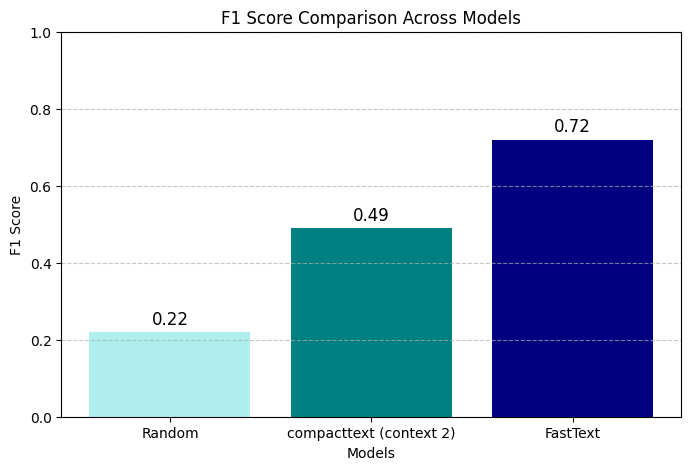

In [52]:
models = ["Random", "compacttext (context 2)", "FastText"]

f1_scores = [0.22, 0.49, 0.72]

plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color=['paleturquoise', 'teal', 'navy'])

plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison Across Models")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, score in enumerate(f1_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=12)

plt.show()

#### Concept Categorization Test (BLESS)
* Reading the dataset (csv file)
* `category1` : `[word 1 , word 2 , ... , word n]`
* `category2` : `[word 1 , word 2 , ... , word n]`
* ...
* The goal is to cluster all the words in vector space and evaluate the final clustering based on the number of categories.
* Evaluation is carried out using Silhouette score

In [53]:
import pandas as pd

concepts_df = pd.read_csv('Evals/bless_concept.csv')

# concepts_df_2 = pd.read_csv('Evals/ap.csv')
# concepts_df = pd.concat([concepts_df , concepts_df_2])

concepts_df.dropna(inplace=True)
concepts_df

,Unnamed: 0,category,word
0,0,fish,carp
1,1,fish,catfish
2,2,fish,cod
3,3,fish,dolphin
4,4,fish,goldfish
...,...,...,...
211,211,tree,elm
212,212,tree,oak
213,213,tree,pine
214,214,tree,poplar


In [54]:
cluster_poster_boys = list(set(np.array(concepts_df['category'])))

words_per_cluster = []
for target in cluster_poster_boys:
    words_per_cluster.append(list(concepts_df.loc[concepts_df["category"] == target, "word"]))

cluster_poster_boys[0] , " " , words_per_cluster[0]

('furniture',
 ' ',
 ['bed',
  'bookcase',
  'chair',
  'couch',
  'desk',
  'dresser',
  'sofa',
  'table',
  'wardrobe'])

Silhouette Scores Analysis (HIGER THE BETTER)


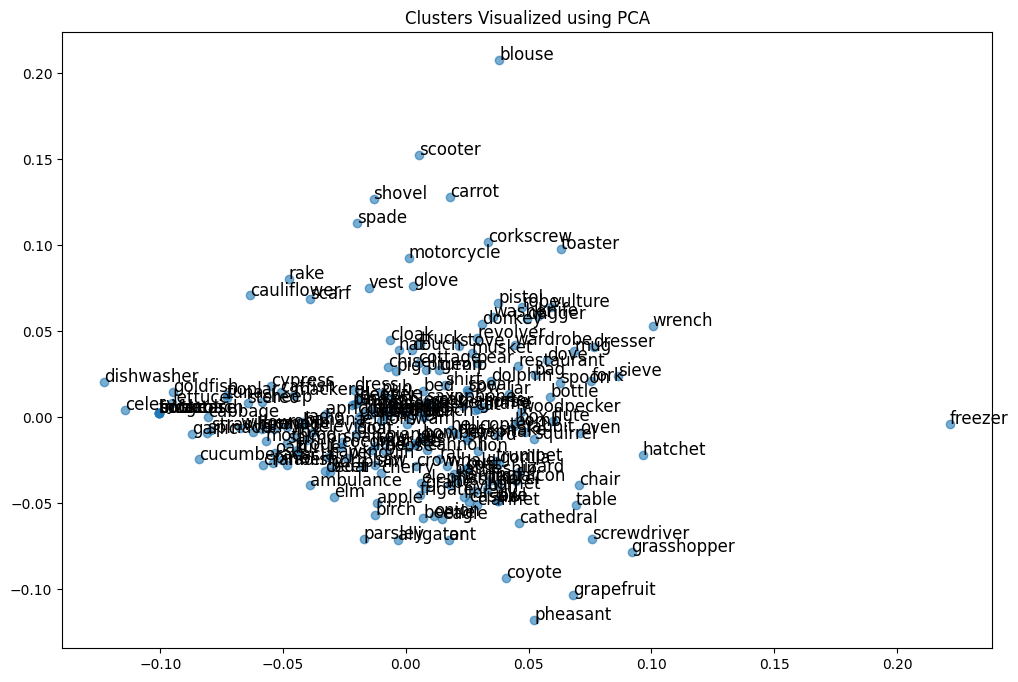

Generated Embeddings Silhouette Score : -0.1389


In [55]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import random

def evaluate_clustering(word_embeddings , target_labels , words_per_cluster , dims=254):
    # apply PCA
    word_embeddings = word_embeddings.reshape(-1,dims)
    pca = PCA(n_components=2)
    pca.fit(word_embeddings)
    embeddings_pca = pca.transform(word_embeddings)

    all_words = [w for w_list in words_per_cluster for w in w_list]

    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.6)

    for i, word in enumerate(all_words):
        plt.annotate(word , (embeddings_pca[i, 0], embeddings_pca[i, 1]), fontsize=12)

    plt.title("Clusters Visualized using PCA")
    plt.show()
    
    return silhouette_score(word_embeddings, target_labels)

print(f"Silhouette Scores Analysis (HIGER THE BETTER)")

my_model = model_compact_w2
word_vectors = []
cluster_labels = []
for i in range(len(cluster_poster_boys)):
    cur_words = words_per_cluster[i]
    for w in cur_words:
        w_vec = my_model[precog_utils.get_processed_token_idx(w , filtered_vocab , word_to_index)]
        word_vectors.append(w_vec)
        cluster_labels.append(i)
    # if i == 2:
    #     break

print(f"Generated Embeddings Silhouette Score : {evaluate_clustering(np.array(word_vectors) , np.array(cluster_labels) , words_per_cluster , 254):.4f}")

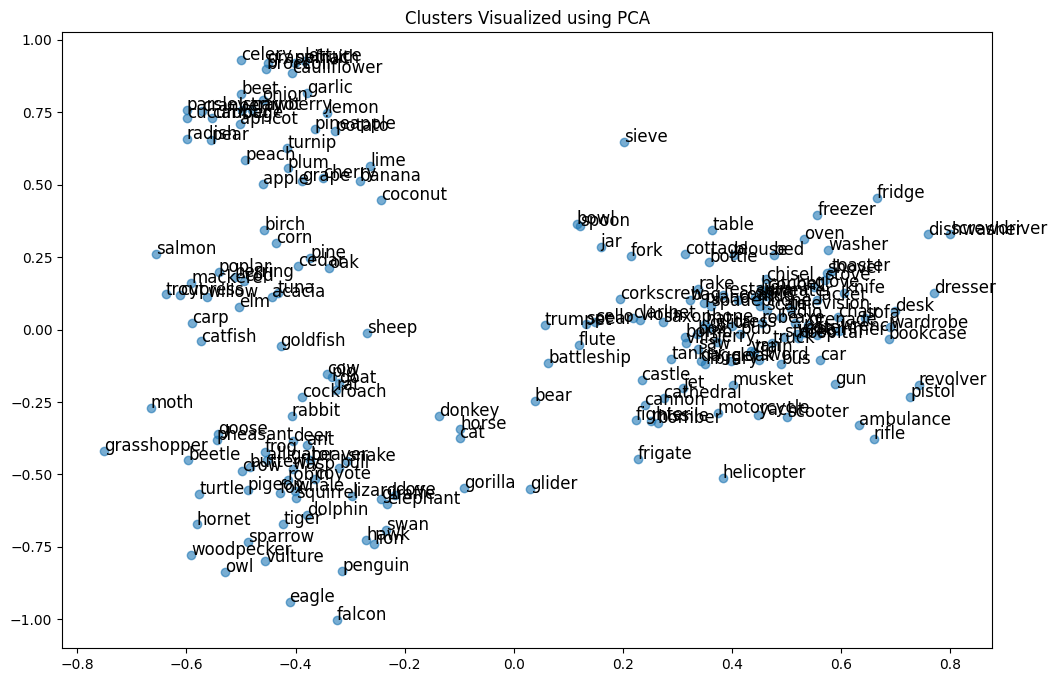

FastText Embeddings Silhouette Score : 0.0658


In [56]:
fasttext_word_vectors = []
cluster_labels = []
for i in range(len(cluster_poster_boys)):
    cur_words = words_per_cluster[i]
    for w in cur_words:
        w_vec = precog_utils.get_fasttext_embedding(w , fasttext_embeddings)
        fasttext_word_vectors.append(w_vec)
        cluster_labels.append(i)
    # if i == 2:
    #     break

print(f"FastText Embeddings Silhouette Score : {evaluate_clustering(np.array(fasttext_word_vectors) , np.array(cluster_labels) , words_per_cluster , 300):.4f}")

#### old testing attempts...

In [57]:
index = 4
cur_target = cluster_poster_boys[index]
cur_words = words_per_cluster[index]

print(cur_target , cur_words)

my_model = model_compact_w5
fasttext_model = fasttext_embeddings

target_emb = my_model[precog_utils.get_processed_token_idx(cur_target , filtered_vocab , word_to_index)]
target_fasttext = precog_utils.get_fasttext_embedding(cur_target , fasttext_model)

model1_embeddings = np.array([my_model[precog_utils.get_processed_token_idx(w , filtered_vocab , word_to_index)] for w in cur_words])
model2_embeddings = np.array([precog_utils.get_fasttext_embedding(w , fasttext_model) for w in words_per_cluster[0]])

clothes ['blouse', 'cloak', 'coat', 'dress', 'glove', 'hat', 'jacket', 'robe', 'scarf', 'shirt', 'sweater', 'vest']


In [58]:
dist_emb = [ np.linalg.norm(emb - target_emb) for emb in model1_embeddings ]
dist_fasttext = [ np.linalg.norm(emb - target_fasttext) for emb in model2_embeddings ]

In [59]:
dist_emb_norm = (dist_emb - np.min(dist_emb)) / (np.max(dist_emb) - np.min(dist_emb))
dist_fasttext_norm = (dist_fasttext - np.min(dist_fasttext)) / (np.max(dist_fasttext) - np.min(dist_fasttext))

In [247]:
np.mean(dist_emb_norm) , np.mean(dist_fasttext_norm)

(0.2758230714040386, 0.37263761926175476)

In [248]:
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(dist_emb, dist_fasttext)
print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

KS Statistic: 1.0, p-value: 3.685684800235884e-05
